In [1]:
# please ignore this cell for now

# these settings perform better for CPU training at CIP
# for the particular model we have here
import os
nthreads = 4
os.environ["OMP_NUM_THREADS"] = str(nthreads)
os.environ["MKL_NUM_THREADS"] = str(nthreads)
import tensorflow as tf
import keras.backend as K
config = tf.ConfigProto(
    intra_op_parallelism_threads=nthreads,
    inter_op_parallelism_threads=nthreads,
)
session = tf.Session(config=config)
K.set_session(session)

Using TensorFlow backend.


# A particle physics application for CNNs: Top quark tagging

This tutorial uses a lot of material from Lisa Benato and Dirk Krücker (https://github.com/dkgithub/wuhan_DL_labs)

### The Standard Model and the top quark

<br>
<img src="figures/top_tagging/SM.png" width="400" >

The **Standard Model** of elementary particles represents our knowledge of the microscopic world. It describes the matter constituents (quarks and leptons) and their interactions (mediated by bosons), that are the electomagnetic, the weak and the strong interactions.

Among all these particles, the **top quark** still represents a very peculiar case. It is the heaviest known elementary particle (mass of 172.5 GeV) and it has a very short lifetime ($10^{-25}$ seconds): this means we can only see its decay products. It has been discovered in 1995 by CDF and D0 experiments at Tevatron (Fermilab, Chicago). The top quark is considered a key particle to searches for new physics beyond the Standard Model and to precision measurements.

The ideal tool for measuring the top quark properties is a particle collider. The **Large Hadron Collider** (LHC), situated nearby Geneva, between France and Switzerland, is the largest proton-proton collider ever built on Earth. It consists into a 27 km circumference ring, where proton beams are smashed at a centre-of-mass energy of 13 TeV (99.999999% of speed of light). At the LHC, 40 Million collisions / second occurs, providing an enormous amount of data. Thanks to these data, **ATLAS** and **CMS** experiments discovered the missing piece of the Standard Model, the Higgs boson, in 2012.

During a collision, the energy is so high that protons are "broken" into their fundamental components, i.e. **quarks** and **gluons**, that can interact together, producing particles that we don't observe in our everyday life, such as the top quark. The production of a top quark is, by the way, a relatively "rare" phenomenon, since there are other physical processes that occur way more often, such those initiated by strong interaction, producing lighter quarks (such as up, down, strange quarks). In high energy physics, we speak about the **cross-section** of a process. We say that, the top quark production has a smaller cross-section than the production of light quarks.

The experimental consequence is that distinguishing the decay products of a top quark from a light quark can be extremely difficult, given that the latter phenomenon has a way larger probability to happen.

### Experimental signature of top quark in a particle detector

Let's first understand what are the experimental signatures and how our detectors work. This is a sketch of the CMS experiment.

<br>
<img src="figures/top_tagging/EPS_CMS_Slice.png" width="1000" >

A collider detector is organized in layers: each layer is able to distinguish and measure different particles and their properties. For example, the silicon tracker detects each particle that is charged. The electromagnetic calorimeter detects photons and electrons. The hadronic calorimeter detects hadrons (such as protons and neutrons). The muon chambers detect muons (that have a long lifetime and travel through the inner layers).

Our physics problem consists into detecting the so-called "hadronic decay" of a top quark. The decay chain is sketched here: the top quark decays into a bottom quark and into a $W$ boson, that in turn decays into light quarks (in the picture, up and down quarks).

<br>
<img src="figures/top_tagging/top.png" width="500" >

Our background is, instead, represented by light quark (or quarks) produced by the strong interaction (in jargon, QCD). Here we have a sketch of one possible background event.

<br>
<img src="figures/top_tagging/QCD.png" width="200" >

#### Jets

Without going into the theoretical details, the nature of particles experiencing the strong interaction (like quarks) is such that they cannot travel free, but they are forced to be "confined" into hadrons. One hadron can be seen as a "combination" of quarks. Let's think about the electromagnetic interaction: a positive charge and a negative charge are attracted to each other, and they will tend to form a state that is neutral under the electromagnetic interaction. Analogously, quarks try to combine together, forming a bond state that is neutral under the strong interaction. This process is called **hadronization**, and it has a very important consequence. Quarks won't appear as single isolated particles in a detetctor, but rather as **jets** of particles.

There are many different algorithms that are able to reconstruct quarks (and gluons) as jets (i.e., anti-$k_T$ algorithm https://arxiv.org/abs/0802.1189). They basically loop over the shower of particles produced by the hadronization, trying to cluster them together as one single entity. The algorithms are designed such in a way that the momentum of the clustered jet is proportional to the initial energy of the quark. A sketch giving an intuitive idea of a jet is displayed here (Klaus Rabbertz, KIT):

<br>
<img src="figures/top_tagging/Rabbertz_from_quark_to_rec_jet.png" width="500" >

#### Jets substructure

Many physically motivated approaches have been used in the past to distinguish a jet initiated by a top quark from jets due to QCD. One remarkable property is the so-called **jet substructure**. The idea is to try to distinguish how many "sub-jets" are included in a jet. Out of our sketches presented before, since the top quark decays into three separated quarks, we would expect it to show a three-pronged sub-structure. QCD, on the other hand, is mainly due to single quark/gluon radiation, hence it shows a one-pronged sub-structure. One largely used approach to study the jet substructure is the so called *n-subjettiness* (https://arxiv.org/abs/1011.2268).

## The dataset

The authors of [arXiv: 1707.08966](https://arxiv.org/abs/1707.08966) provide us a dataset for studying this problem. There is also a [summary paper](https://arxiv.org/abs/1902.09914) reviewing different methods.

We downloaded the data for the course at CIP - if you want to run this excercise at home you can download the data at https://desycloud.desy.de/index.php/s/llbX3zpLhazgPJ6

In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
data_dir = "/large_tmp/LMU_DA_ML_19Adv/top_tagging"

In [4]:
# the dataset contains about 1M training examples - for now we will just use 100k, for each train, val, test
n_examples = 100000
df_train = pd.read_hdf(os.path.join(data_dir, "train.h5"), "table", stop=n_examples)
df_val = pd.read_hdf(os.path.join(data_dir, "val.h5"), "table", stop=int(n_examples / 10))
df_test = pd.read_hdf(os.path.join(data_dir, "test.h5"), "table", stop=int(n_examples / 5))

The dataset contains the Lorentz Vectors $(E, p_x, p_y, p_z)$ for the leading 200 constituents of the jets. The field `is_signal_new` flags wether the jet is a QCD jet (0) or a Top quark jet (1).

In [5]:
df_train.head()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,E_199,PX_199,PY_199,PZ_199,truthE,truthPX,truthPY,truthPZ,ttv,is_signal_new
375,474.071136,-250.347031,-223.651962,-334.738098,103.236237,-48.866222,-56.790775,-71.025490,105.255569,-55.415001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
377,150.504532,120.062393,76.852005,-48.274265,82.257057,63.801739,42.754807,-29.454842,48.573559,36.763199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
378,251.645386,10.427651,-147.573746,203.564880,104.147797,10.718256,-54.497948,88.101395,78.043213,5.724113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
379,451.566132,129.885437,-99.066292,-420.984100,208.410919,59.033958,-46.177090,-194.467941,190.183304,54.069675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
380,399.093903,-168.432083,-47.205597,-358.717438,273.691956,-121.926941,-30.803854,-243.088928,152.837219,-44.400204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


## Jet images -  a nail for the hammer?

In the previous notebook we saw the power of convolutional neural networks when it comes to image classification. Can we transform our jet constituent data into an image? Yes we can! We unroll the cylindrical surface of the detector along the azimuthal and longitudinal coordinates and subdivide the area into pixels. The pixel values then correspond to the energy deposits (component transverse to the beam direction) of our jet constituents. Here we will use this as a grayscale image, but in principle one could use multiple features, similar to the colours of images with more information than just the energy (e.g. number of particles, energy for neutral and charged particles as done in https://arxiv.org/abs/1612.01551)

<br>
<img src="figures/top_tagging/images_jets.png" width="800" >

(Figure from https://arxiv.org/abs/1612.01551)

## Preprocessing

Since our jets are already clustered with a fixed radius parameter it is convenient to transform the coordinates such that the leading constituent is in the center of the image. As azimuthal and longitudinal coordinates we use the angle $\phi$ and the [pseudorapidity](https://en.wikipedia.org/wiki/Pseudorapidity) $\eta$, a quantity where differences are invariant under boost in beam direction. The images will be created by summing (histogramming) transverse momentum values into 40x40 pixels and normalize by the leading constituents transverse momentum (center of the image).

In [6]:
def get_df_rel(df):
    """
    Create dataframe with PT, ETA, PHI in coordinates relative to leading constituent
    """

    # make new df with relative coordinates (to leading constituent)
    # first, just copy the labels for convenience
    df_rel = df[["is_signal_new"]].copy()

    # Augment with pt, eta, phi
    for i in range(200):
        df_rel["PT_{}".format(i)] = np.sqrt(df["PX_{}".format(i)]**2 + df["PY_{}".format(i)]**2)
        df_rel["ETA_{}".format(i)] = np.arcsinh(df["PZ_{}".format(i)]/df_rel["PT_{}".format(i)])
        df_rel["PHI_{}".format(i)] = np.arcsin(df["PY_{}".format(i)]/df_rel["PT_{}".format(i)])

    PT_0 = df_rel.PT_0.copy()
    ETA_0 = df_rel.ETA_0.copy()
    PHI_0 = df_rel.PHI_0.copy()
    for i in range(200):
        # normalize by leading constituent
        df_rel["PT_{}".format(i)] = df_rel["PT_{}".format(i)] / PT_0
        
        # shift coordinates
        df_rel["ETA_{}".format(i)] = df_rel["ETA_{}".format(i)] - ETA_0
        df_rel["PHI_{}".format(i)] = df_rel["PHI_{}".format(i)] - PHI_0

    df_rel.fillna(0, inplace=True)
    return df_rel

In [7]:
df_rel_train = get_df_rel(df_train)

/home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in arcsinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
df_rel_train.head()

,is_signal_new,PT_0,ETA_0,PHI_0,PT_1,ETA_1,PHI_1,PT_2,ETA_2,PHI_2,...,PHI_196,PT_197,ETA_197,PHI_197,PT_198,ETA_198,PHI_198,PT_199,ETA_199,PHI_199
375,0,1.0,0.0,0.0,0.223178,0.035219,-0.131122,0.222274,0.001588,-0.004627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
377,0,1.0,0.0,0.0,0.538767,-0.042203,0.021005,0.319934,-0.026253,0.063912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
378,0,1.0,0.0,0.0,0.375431,0.117713,0.123651,0.296042,0.056809,0.060529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
379,0,1.0,0.0,0.0,0.458814,-0.006326,-0.012208,0.417949,-0.008213,-0.005196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
380,0,1.0,0.0,0.0,0.718937,0.052834,0.025791,0.286885,-0.312650,-0.211530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


How does an average jet image look like now?

In [9]:
import matplotlib
import matplotlib.pyplot as plt

In [10]:
def plot_avg(df, label=1):
    
    # transform to reshaped numpy array of particles (irrespective of event)
    trf = df[df["is_signal_new"]==label][
        sum([["PT_{}".format(i), "ETA_{}".format(i), "PHI_{}".format(i)] for i in range(200)], [])
    ].values.reshape(-1, 3)
    pt = trf[:,0]
    eta = trf[:,1]
    phi = trf[:,2]

    plt.hist2d(
        eta, phi, bins=(40, 40), range=([-1, 1], [-1, 1]),
        # the pixel intensity is the transverse momentum, so we have to weight by pt here
        weights=pt,
        norm=matplotlib.colors.LogNorm(),
    )
    plt.colorbar()
    plt.xlabel("eta")
    plt.ylabel("phi")

Average QCD jet

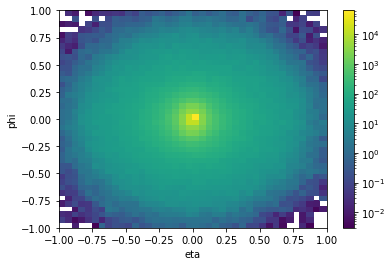

In [11]:
plot_avg(df_rel_train, label=0)

Average Top quark jet

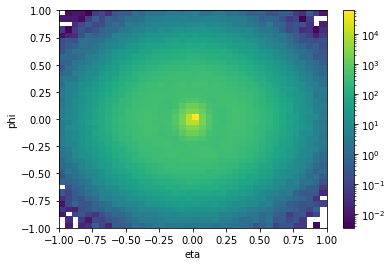

In [12]:
plot_avg(df_rel_train, label=1)

One can see a faint "ring" around the center for top quark jets - potentially coming from the additional high momentum constituents in the top quark decay. This could be made more visible with a more sophisticated transformation, but we leave it as it is now.

For training a CNN we now have to make an array of these images:

In [13]:
def get_img_array(df):
    """
    Pixelate constituent arrays per jet
    """
    columns = sum([["PT_{}".format(i), "ETA_{}".format(i), "PHI_{}".format(i)] for i in range(200)], [])
    hists = []
    trf = df[columns].values.reshape(-1, 200, 3)
    for i in range(len(trf)):
        pt = trf[i][:,0]
        eta = trf[i][:,1]
        phi = trf[i][:,2]
        # remember: the pixel intensity is the transverse momentum, so we have to weight by pt here
        hist, xedges, yedges = np.histogram2d(eta, phi, bins=(40, 40), range=([-1, 1], [-1, 1]), weights=pt)
        hists.append(np.array([hist]))
    return np.stack(hists).reshape(-1, 40, 40, 1)

In [14]:
x_train = get_img_array(df_rel_train)

In [15]:
y_train = df_rel_train.is_signal_new.values

In [16]:
def show_random_pictures(x):
    pictures = x
    rnd_idx = np.random.permutation(len(pictures))
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
    for i, ax in enumerate(axs.reshape(-1)):
        picture = pictures[rnd_idx[i]]
        ax.imshow(picture.reshape(picture.shape[:-1]), cmap='inferno')

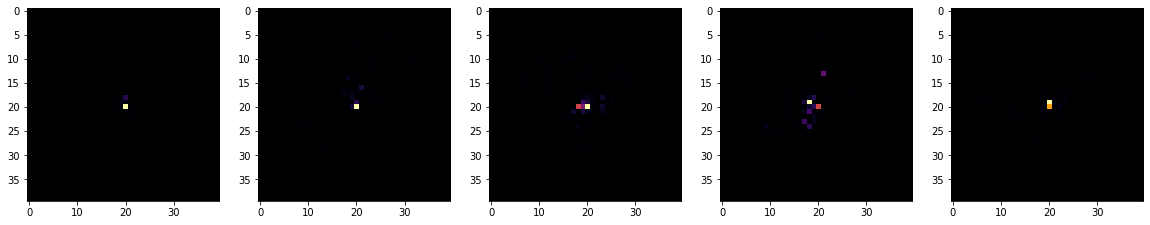

In [17]:
show_random_pictures(x_train[y_train==0])

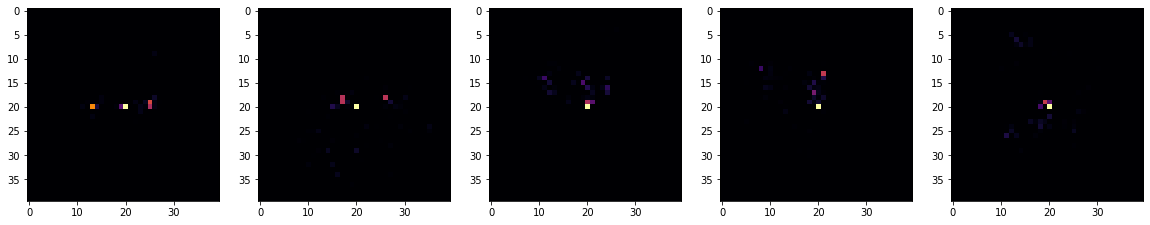

In [18]:
show_random_pictures(x_train[y_train==1])

As you can see the pictures are rather sparse compared to typical images

## NN and training

Let's use the same model we had in the [previous exercise](CNNIntro.ipynb). This time we have a binary classification (top vs QCD jets) so we let the NN output a single value between 0 and 1 (similar to the exercise in [NNFromScratch.ipynb](NNFromScratch.ipynb)).

In [19]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

In [20]:
model = keras.models.Sequential([
    Conv2D(32, 3, activation="relu", input_shape=(40, 40, 1)),
    Conv2D(32, 3, activation="relu"),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, 3, activation="relu"),
    Conv2D(64, 3, activation="relu"),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

W0825 17:37:55.330278 140306271319808 deprecation_wrapper.py:119] From /home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 17:37:55.331918 140306271319808 deprecation_wrapper.py:119] From /home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 17:37:55.334274 140306271319808 deprecation_wrapper.py:119] From /home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0825 17:37:55.354192 140306271319808 deprecation_wrapper.py:119] From /home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool 

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 38, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

We have a few more parameters now in the final Dense layer, since our images are a bit larger

In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

W0825 17:37:55.441421 140306271319808 deprecation_wrapper.py:119] From /home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0825 17:37:55.458838 140306271319808 deprecation_wrapper.py:119] From /home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0825 17:37:55.461600 140306271319808 deprecation.py:323] From /home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    shuffle=True,
    epochs=2,
    # this time we explicitely pass the validation data since we have it anyway
    validation_data=(
        # x
        get_img_array(get_df_rel(df_val)),
        # y
        df_val.is_signal_new.values
    )
)

/home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in arcsinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)


Train on 100000 samples, validate on 10000 samples
Epoch 1/2
100000/100000 [==============================] - 114s 1ms/step - loss: 0.3086 - acc: 0.8701 - val_loss: 0.2549 - val_acc: 0.8908
Epoch 2/2
100000/100000 [==============================] - 112s 1ms/step - loss: 0.2714 - acc: 0.8860 - val_loss: 0.2393 - val_acc: 0.9024


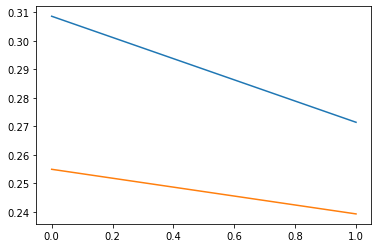

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

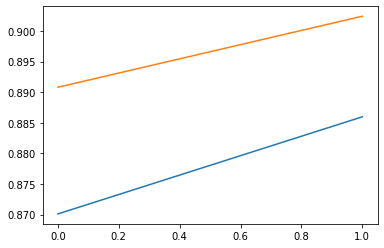

In [25]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

## ROC curve

This classification problem is an example where the numbers of candidates for each class will be very asymmetric in the actual application (although we still train with the same number for both labels).

Depending on how the classifier is used there might be much more background from QCD jets than the actual top quark jet signal. Therefore metrics such as the accuracy are not really helpful here and instead we look at the "ROC" curve that shows the true positive rate against the false positive rate (or vice versa).

In [26]:
x_test = get_img_array(get_df_rel(df_test))
y_test = df_test.is_signal_new.values

/home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in arcsinh
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
# this time the output is just a value between 0 and 1 for each instance
scores = model.predict(x_test)

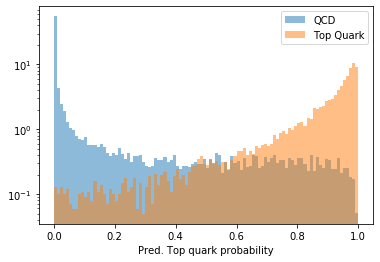

In [28]:
opt=dict(bins=100, range=(0, 1), alpha=0.5, density=True)
plt.hist(scores[y_test==0], label="QCD", **opt)
plt.hist(scores[y_test==1], label="Top Quark", **opt)
plt.yscale("log")
plt.xlabel("Pred. Top quark probability")
plt.legend()

The following function will give numbers for true postitive rate (TPR, here the top tagging efficiency), false positive rate (FPR, here the QCD jet fake rate) and the corresponding thresholds where we would need to cut the output to get the FPR, TPR pairs.

In [29]:
from sklearn.metrics import roc_curve

In [30]:
fpr, tpr, thr = roc_curve(y_test, scores)

Text(0, 0.5, 'True positive rate (Top quark jet efficiency)')

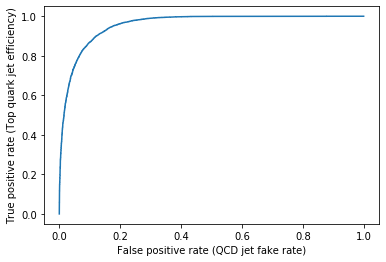

In [31]:
plt.plot(fpr, tpr)
plt.xlabel("False positive rate (QCD jet fake rate)")
plt.ylabel("True positive rate (Top quark jet efficiency)")

Since the most interesting region might be where the rejection of Gluon jets is very high (to the very left in the plot above) it is convenient to plot the true positive rate against the inverse of the false positive rate with logarithmic y-scale:

/home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


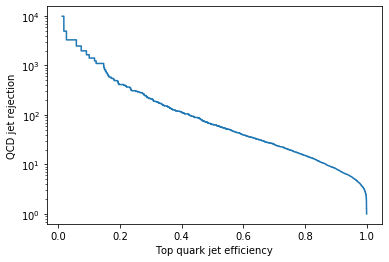

In [32]:
plt.plot(tpr, 1. / fpr)
plt.ylabel("QCD jet rejection")
plt.xlabel("Top quark jet efficiency")
plt.yscale("log")

Top quark jet efficiency at 0.1% QCD jet fake rate (rejection $10^3$)

In [33]:
np.max(tpr[fpr < 0.001])

0.14679170779861797

QCD jet rejection at 30% Top quark jet efficiency

In [34]:
1. / np.min(fpr[tpr > 0.3])

209.99999999999997